In [1]:
# 测试训练好的模型
# 1.从权重中加载模型
# 2.对test_data进行测试，把标注和预测的结果作对比
# 3.生成动画
# 4.预测一下imagesTs下的文件

In [2]:
import torch

C:\conda\envs\course_unet_seg\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 定义两次卷积操作
class ConvBlock(torch.nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        
        self.step = torch.nn.Sequential(
            # 第一次卷积
            torch.nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,padding=1,stride=1),
            # ReLU
            torch.nn.ReLU(),
            # 第二次卷积
            torch.nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size=3,padding=1,stride=1),
            # ReLU
            torch.nn.ReLU()
        )
    
    def forward(self,x):
        
        return self.step(x)
    

In [4]:
class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 定义左侧编码器的操作
        self.layer1 = ConvBlock(1,64)
        self.layer2 = ConvBlock(64,128)
        self.layer3 = ConvBlock(128,256)
        self.layer4 = ConvBlock(256,512)
        
        # 定义右侧解码器的操作
        self.layer5 = ConvBlock(256+512,256)
        self.layer6 = ConvBlock(128+256,128)
        self.layer7 = ConvBlock(64+128,64)
        
        #最后一个卷积
        self.layer8  = torch.nn.Conv2d(in_channels=64,out_channels=1,kernel_size=1,padding=0,stride=1)
        
        # 定一些其他操作
        # 池化
        self.maxpool = torch.nn.MaxPool2d(kernel_size=2)
        #上采样
        self.upsample = torch.nn.Upsample(scale_factor=2,mode='bilinear')
        # sigmoid
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self,x):
        # 对输入数据进行处理
        
        # 定义下采样部分
        
        # input:1X256x256, output: 64x256x256
        x1 = self.layer1(x)
        # input:64x256x256, output: 64 x 128 x 128
        x1_p = self.maxpool(x1)
        
        # input:  64 x 128 x 128 , output: 128 x 128 x 128
        x2 = self.layer2(x1_p)
        # input:128 x 128 x 128 , output: 128 x 64 x 64
        x2_p = self.maxpool(x2)
        
        # input: 128 x 64 x 64, output: 256 x 64 x 64
        x3 = self.layer3(x2_p)
        #input:256 x 64 x 64, output: 256 x 32 x 32
        x3_p = self.maxpool(x3)
        
        #input: 256 x 32 x 32, output: 512 x 32 x 32
        x4 = self.layer4(x3_p)
        
        
        
        # 定义上采样
        # input: 512 x 32 x 32，output: 512 x 64 x 64
        x5 = self.upsample(x4)
        # 拼接,output: 768x 64 x 64
        x5 = torch.cat([x5,x3],dim=1)
        # input: 768x 64 x 64,output: 256 x 64 x 64
        x5 = self.layer5(x5)
        
        # input: 256 x 64 x 64,output: 256 x 128 x 128
        x6  = self.upsample(x5)
        # 拼接,output: 384 x 128 x 128
        x6 = torch.cat([x6,x2],dim=1)
        # input: 384 x 128 x 128, output: 128 x 128 x 128
        x6 = self.layer6(x6)
        
        
        # input:128 x 128 x 128, output: 128 x 256 x 256
        x7 = self.upsample(x6)
        # 拼接, output: 192 x 256 x256
        x7 = torch.cat([x7,x1],dim=1)
        # input: 192 x 256 x256, output: 64 x 256 x 256
        x7 = self.layer7(x7)
        
        # 最后一次卷积,input: 64 x 256 x 256, output: 1 x 256 x 256
        x8 = self.layer8(x7)
        
        #sigmoid
        # x9= self.sigmoid(x8)
        
        
        
        return x8
        
        
        

In [5]:
# 实例化
model = UNet().to('cuda:0')

In [6]:
# 恢复权重
model.load_state_dict(torch.load('saved_model/back_up/unet_best_bce.pt'))

<All keys matched successfully>

In [7]:
model.eval()

UNet(
  (layer1): ConvBlock(
    (step): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (layer2): ConvBlock(
    (step): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (layer3): ConvBlock(
    (step): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (layer4): ConvBlock(
    (step): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )


In [8]:
# 推理

In [9]:
import torch
from torch.utils.data import Dataset,DataLoader
import numpy as np
import matplotlib.pyplot as plt
import glob
# 数据增强相关包
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

from natsort import natsorted 

In [10]:
class SegmentDataset(Dataset):
    def __init__(self,where='train',seq=None):
        # 获取numpy文件数据
        # 图片列表
        self.img_list =natsorted( glob.glob('processed/{}/*/img_*'.format(where)) )
        # self.mask_list = glob.glob('processed/{}/*/label_*'.format(where))
        # 数据增强的处理流程
        self.seq = seq
        
    def __len__(self):
        # 获取数据集大小
        return len(self.img_list)
    
    def __getitem__(self,idx):
        # 获取具体某一个数据
        
        # 获取图片文件名
        img_file = self.img_list[idx]
        # 获取标注文件名
        mask_file = img_file.replace('img','label')
        
        # 加载数据
        img = np.load(img_file)
        mask = np.load(mask_file)
        
        # 数据增强处理
        if self.seq:
            segmap = SegmentationMapsOnImage(mask,shape=mask.shape)
            img,mask = self.seq(image=img, segmentation_maps=segmap)
            # 获取数组内容
            mask = mask.get_arr()

            
        # 扩张维度变成张量
        return np.expand_dims(img,0),np.expand_dims(mask,0)

In [11]:
# 使用dataloader加载数据
batch_size = 12
num_workers = 0

test_dataset = SegmentDataset('test',None)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=False)

In [12]:
len(test_dataset)

339

In [13]:
#将画面合成为动画
from celluloid  import Camera
from IPython.display import HTML
import tqdm

  0%|                                                                                          | 0/339 [00:00<?, ?it/s]C:\conda\envs\course_unet_seg\lib\site-packages\torch\nn\functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 339/339 [00:18<00:00, 18.83it/s]


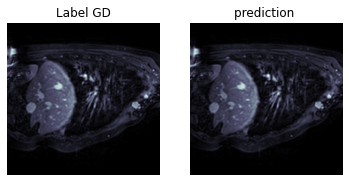

In [14]:
#遍历每一层图像和mask
fig = plt.figure()
camera = Camera(fig)

# 遍历所有数据
for x,y in tqdm.tqdm(test_dataset):
    
    # 处理输入
    input = torch.tensor([x]).to('cuda:0',dtype=torch.float32)
    # 推理
    y_pred = model(input)
    
    # 获取对应的mask（筛选阈值0.5）
    mask_data = (y_pred.detach().cpu().numpy()[0][0] > 0.5)
    
    # 作比对，左侧显示标注，右侧显示实际推理
    plt.subplot(1,2,1)
    # 显示图片
    plt.imshow(x[0],cmap='bone')
    
    mask = np.ma.masked_where(y[0]==0,y[0])
    plt.imshow(mask,alpha=0.8,cmap='spring')
    plt.title('Label GD')
    plt.axis('off')
    
    
    plt.subplot(1,2,2)
    # 显示图片
    plt.imshow(x[0],cmap='bone')
    
    mask = np.ma.masked_where(mask_data==False,mask_data)
    plt.imshow(mask,alpha=0.8,cmap='spring')
    plt.title('prediction ')
    plt.axis('off')
    
    camera.snap()
    # break
animation = camera.animate()

In [15]:
HTML(animation.to_html5_video())

In [16]:
# 测试未知图片

In [17]:
import glob
import os 
import nibabel as nib

In [18]:
test_file_list = glob.glob('data/imagesTs/la*')

In [19]:
test_file_list

['data/imagesTs\\la_001.nii.gz',
 'data/imagesTs\\la_002.nii.gz',
 'data/imagesTs\\la_006.nii.gz',
 'data/imagesTs\\la_008.nii.gz',
 'data/imagesTs\\la_012.nii.gz',
 'data/imagesTs\\la_013.nii.gz',
 'data/imagesTs\\la_015.nii.gz',
 'data/imagesTs\\la_025.nii.gz',
 'data/imagesTs\\la_027.nii.gz',
 'data/imagesTs\\la_028.nii.gz']

In [20]:
# 将数据同样进行归一化和标准化处理

In [21]:
#标准化
def standardize(data):
    # 计算均值
    mean = data.mean()
    # 计算标准差
    std = np.std(data)
    
    # 计算结果
    standardized = (data - mean) / std
    return standardized


#  归一化
def normalize(data):
    # 计算最大值和最小值
    max_val = data.max()
    min_val = data.min()
    normalized = (data - min_val) / (max_val - min_val)
    return normalized

In [22]:
# 挑选一个文件测试一下
file = test_file_list[2]

In [23]:
# 读取
img = nib.load(file)
img_data = img.get_fdata()

In [24]:
img_data.shape

(400, 400, 180)

In [25]:
# 边缘裁剪
img_data_crop = img_data[32:-32,32:-32]

In [26]:
img_data_crop.shape

(336, 336, 180)

In [27]:
# 标准化归一化
std = standardize(img_data_crop)
normalized = normalize(std)

In [28]:
normalized.max(),normalized.min()

(1.0, 0.0)

In [29]:
# 将每一层画面进行推理，并合成动画

In [30]:
layer_num  = normalized.shape[-1]

In [31]:
layer_num

180

  0%|                                                                                          | 0/180 [00:00<?, ?it/s]C:\conda\envs\course_unet_seg\lib\site-packages\torch\nn\functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [00:16<00:00, 10.60it/s]


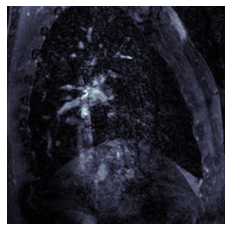

In [32]:
#遍历每一层图像和mask
fig = plt.figure()
camera = Camera(fig)

# 遍历每一层
for i in tqdm.tqdm(range(layer_num)):
    # 获取该层画面
    layer = normalized[:,:,i]
    
    # 处理输入
    input = torch.tensor([[layer]]).to('cuda:0',dtype=torch.float32)
    # 推理
    y_pred = model(input)
    
    # 获取对应的mask（筛选阈值0.5）
    mask_data = (y_pred.detach().cpu().numpy()[0][0] > 0.5)
    
    # 将mask和图片绘制在一起
    img_display = np.rot90(layer)
    mask_display = np.rot90(mask_data)   
    # 将mask_display像素值为0处遮挡起来
    mask = np.ma.masked_where(mask_display==0,mask_display)
    plt.imshow(img_display,cmap='bone')
    plt.imshow(mask,alpha=0.8,cmap='spring')
    # break
    plt.axis('off')
    
    camera.snap()
    
animation = camera.animate()

In [33]:
HTML(animation.to_html5_video())